# Telco Churn Project Notebook 2

In [1]:
import numpy as np
import seaborn as sns
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from math import sqrt
# to turn off pink warning boxes basically for display purposes in class
# import warnings
# warnings.filterwarnings('ignore')

# import splitting and imputing functions
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# classification algorithms
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# classification analysis
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# to see local file system
import os

# import our own modules
import env
import acquire as a
import prepare as p

# jupyter settings
%matplotlib inline

In [2]:
train, val, test = p.wrangle_telco()

In [3]:
train.head().T

,4841,852,2923,4162,4261
customer_id,3714-XPXBW,1236-WFCDV,5099-BAILX,8445-DNBAE,8763-KIAFH
gender,Female,Male,Male,Male,Female
senior_citizen,0,1,1,0,0
partner,No,No,Yes,No,Yes
dependents,No,No,Yes,Yes,Yes
tenure,37,14,43,1,27
phone_service,Yes,Yes,Yes,Yes,Yes
multiple_lines,Yes,No,Yes,Yes,No
online_security,Yes,No,No,No,No internet service
online_backup,Yes,No,Yes,No,No internet service


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3943 entries, 4841 to 2574
Data columns (total 48 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   customer_id                            3943 non-null   object 
 1   gender                                 3943 non-null   object 
 2   senior_citizen                         3943 non-null   int64  
 3   partner                                3943 non-null   object 
 4   dependents                             3943 non-null   object 
 5   tenure                                 3943 non-null   int64  
 6   phone_service                          3943 non-null   object 
 7   multiple_lines                         3943 non-null   object 
 8   online_security                        3943 non-null   object 
 9   online_backup                          3943 non-null   object 
 10  device_protection                      3943 non-null   object 
 11  t

In [5]:
# finally on to some bivariate exploration

train.monthly_charges.mode()


0    20.05
1    20.15
Name: monthly_charges, dtype: float64

In [6]:
train.monthly_charges.median()

70.3

In [7]:
train.monthly_charges.mean()

64.38212021303565

In [8]:
train[train.monthly_charges < 30]['monthly_charges'].value_counts()

20.15    30
20.05    30
19.90    27
19.85    27
20.00    25
         ..
21.15     1
29.70     1
18.75     1
22.95     1
29.45     1
Name: monthly_charges, Length: 132, dtype: int64

In [9]:
train[train.monthly_charges < 30]['monthly_charges'].value_counts().sum()

938

In [10]:
train.shape

(3943, 48)

In [11]:
train.monthly_charges.describe()

count    3943.000000
mean       64.382120
std        30.032871
min        18.250000
25%        35.300000
50%        70.300000
75%        89.650000
max       118.200000
Name: monthly_charges, dtype: float64

In [12]:
# the bottom 25% pays $35.30 or less per month. What plan are they on?
train[train.monthly_charges < 30]['contract_type'].value_counts()

Two year          379
Month-to-month    343
One year          216
Name: contract_type, dtype: int64

In [13]:
# interestingly, customers in the bottom quartile of monthly
# charges are pretty evenly distributed across contract types.
# what if we lower to less than $22/mo?
train[train.monthly_charges < 22]['contract_type'].value_counts()

Month-to-month    261
Two year          238
One year          169
Name: contract_type, dtype: int64

In [14]:
# month-to-month gains share, but still somewhat evenly distributed.
# lets look at the bottom 25% of tenure v. plan-type.
train.tenure.describe()

count    3943.000000
mean       32.248542
std        24.427210
min         0.000000
25%         9.000000
50%        28.000000
75%        55.000000
max        72.000000
Name: tenure, dtype: float64

In [15]:
# 9 months or less for bottom quartile
train[(train['tenure'] <= 9)]['contract_type'].value_counts()

Month-to-month    949
One year           40
Two year           29
Name: contract_type, dtype: int64

In [16]:
# this makes sense as long-term contracts would have to be broken.
# what about at long end of the tenure spectrum?
train[(train['tenure'] >= 55)]['contract_type'].value_counts()

Two year          643
One year          244
Month-to-month    114
Name: contract_type, dtype: int64

In [17]:
train[(train['tenure'] >= 55)]['contract_type'].value_counts(normalize=True)

Two year          0.642358
One year          0.243756
Month-to-month    0.113886
Name: contract_type, dtype: float64

In [18]:
# here two-year contracts are by far the majority

In [19]:
# what about in the upper 25% of monthly cost?
train[train.monthly_charges >= 89.65]['contract_type'].value_counts()

Month-to-month    508
Two year          256
One year          226
Name: contract_type, dtype: int64

In [20]:
train[train.monthly_charges >= 89.65]['contract_type'].value_counts(normalize=True)

Month-to-month    0.513131
Two year          0.258586
One year          0.228283
Name: contract_type, dtype: float64

In [21]:
# refresh memory on distribution of contract type:
train.contract_type.value_counts(normalize=True)

Month-to-month    0.549328
Two year          0.247781
One year          0.202891
Name: contract_type, dtype: float64

In [22]:
# In the upper quartile of monthly charges the distribution of
# contract types is very close to the distribution in the quartile.

In [23]:
# now lets check do bivariates of all categorical features v churn

cat_cols, num_cols = [], []
for col in train.columns:
    if train[col].dtype == 'O':
        cat_cols.append(col)
    else:
        if train[col].nunique() < 10:
            cat_cols.append(col)
        else:
            num_cols.append(col)

In [24]:
cat_cols

['customer_id',
 'gender',
 'senior_citizen',
 'partner',
 'dependents',
 'phone_service',
 'multiple_lines',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'paperless_billing',
 'churn',
 'internet_service_type',
 'contract_type',
 'payment_type',
 'gender_encoded',
 'partner_encoded',
 'dependents_encoded',
 'phone_service_encoded',
 'paperless_billing_encoded',
 'churn_encoded',
 'multiple_lines_No phone service',
 'multiple_lines_Yes',
 'online_security_No internet service',
 'online_security_Yes',
 'online_backup_No internet service',
 'online_backup_Yes',
 'device_protection_No internet service',
 'device_protection_Yes',
 'tech_support_No internet service',
 'tech_support_Yes',
 'streaming_tv_No internet service',
 'streaming_tv_Yes',
 'streaming_movies_No internet service',
 'streaming_movies_Yes',
 'contract_type_One year',
 'contract_type_Two year',
 'internet_service_type_Fiber optic',
 'internet_service_ty

In [25]:
# this now captures all of the encoded columns so removing them here

In [26]:
cat_cols = ['gender',
 'senior_citizen',
 'partner',
 'dependents',
 'phone_service',
 'multiple_lines',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'paperless_billing',
 'internet_service_type',
 'contract_type',
 'payment_type']

In [27]:
num_cols

['tenure', 'monthly_charges', 'total_charges']

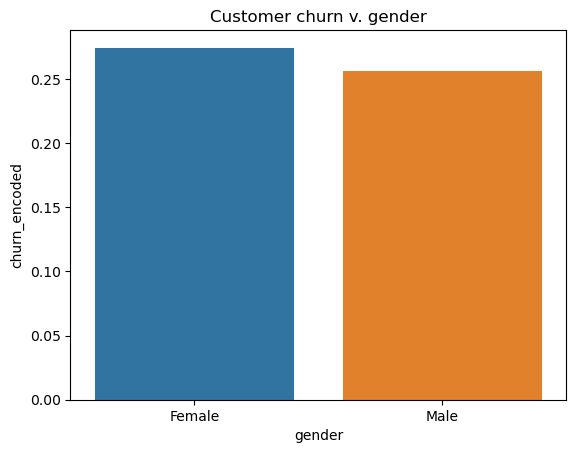

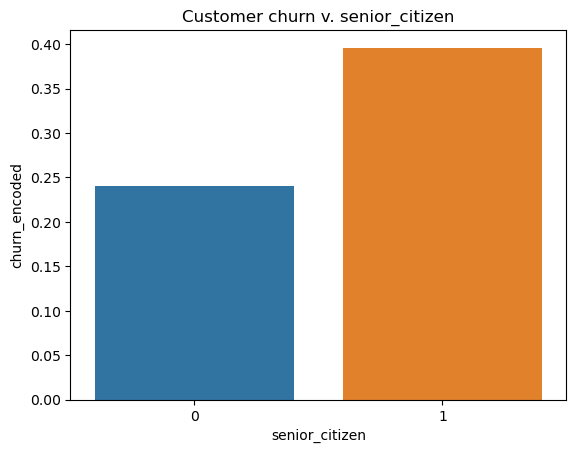

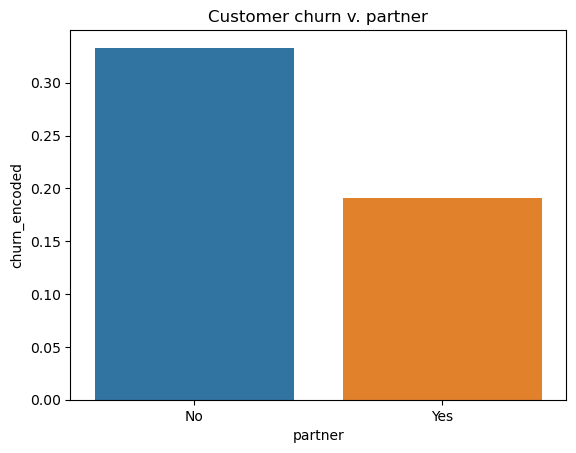

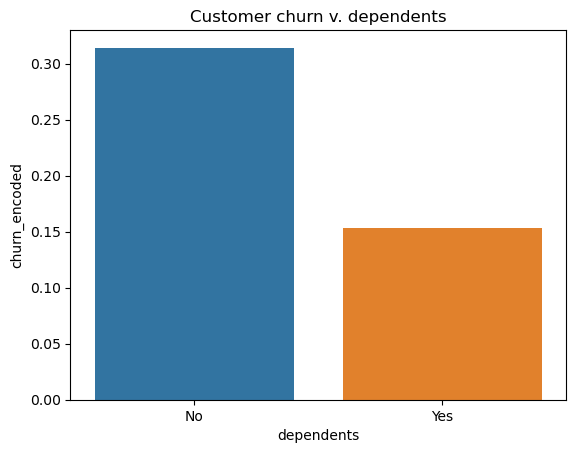

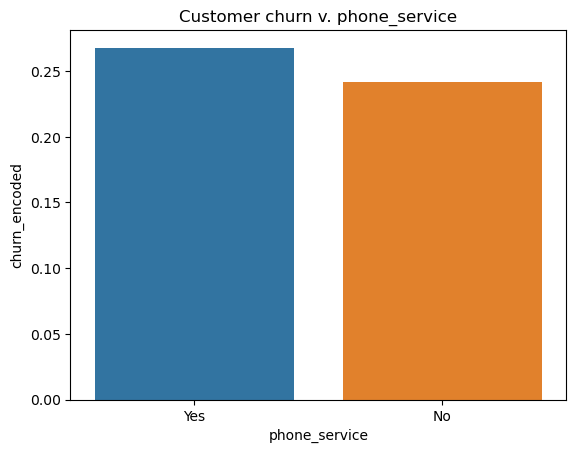

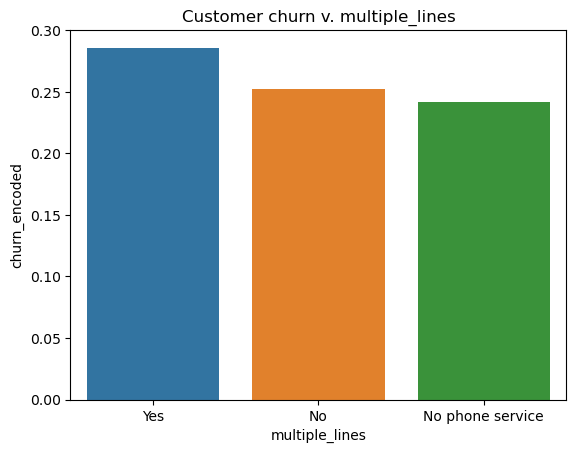

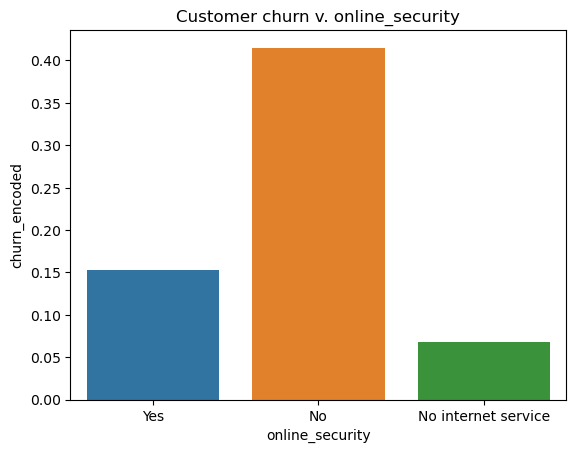

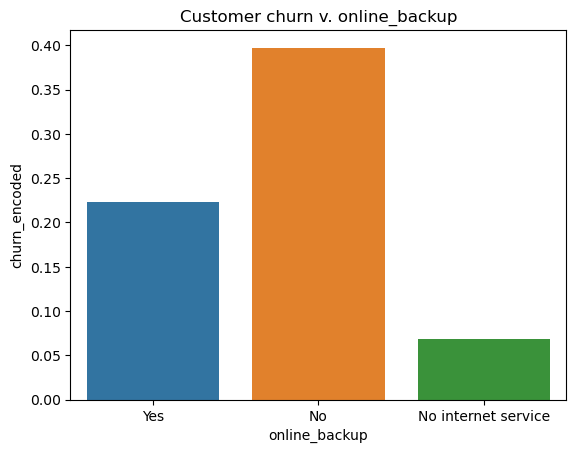

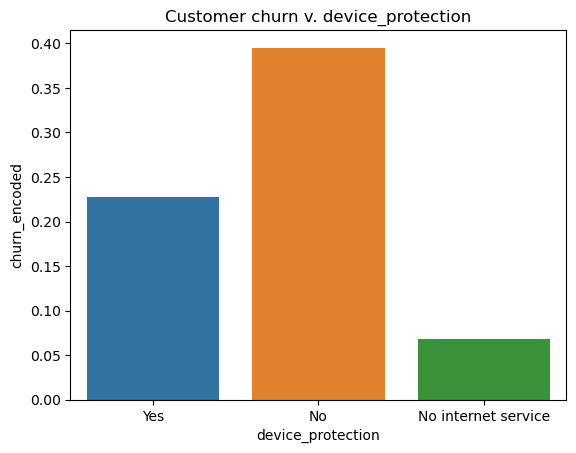

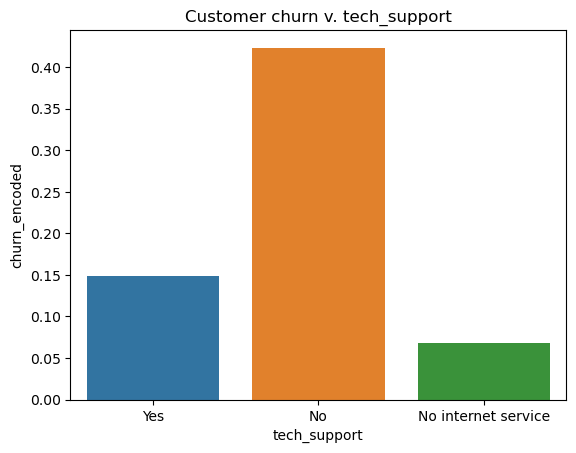

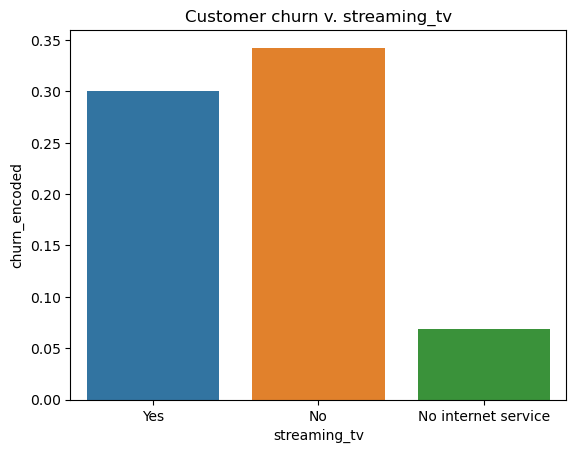

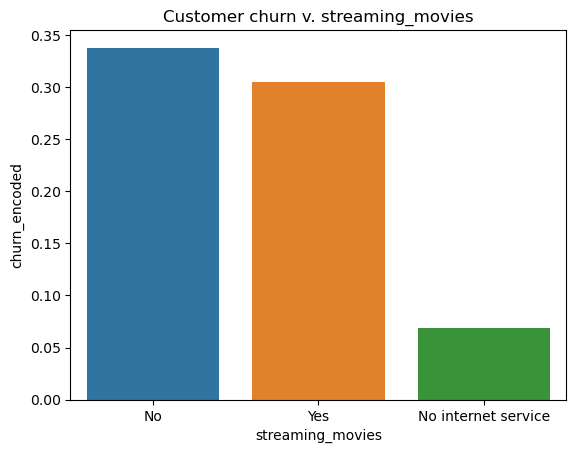

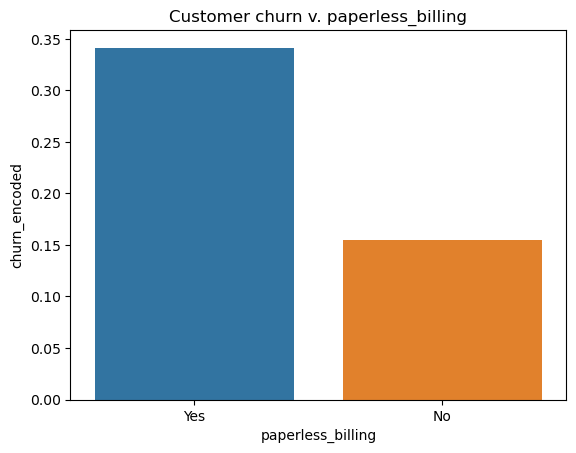

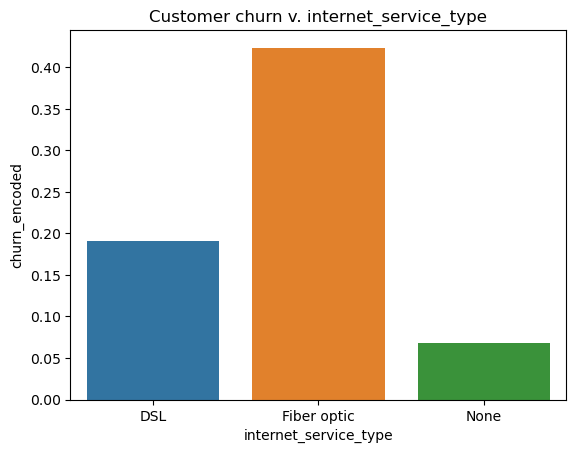

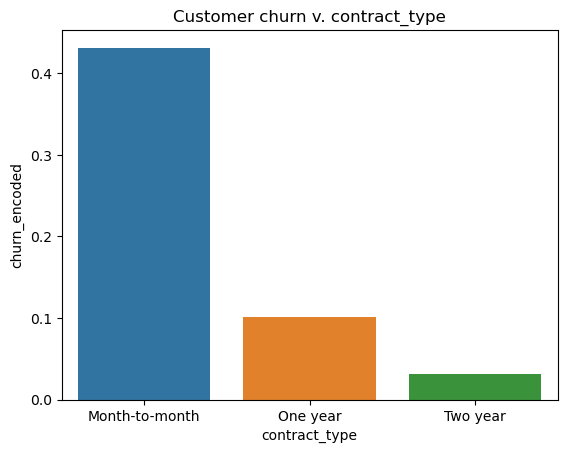

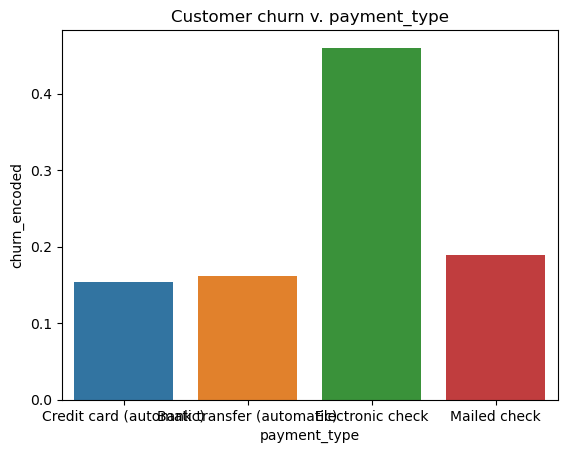

In [28]:
for col in cat_cols:
    if col != 'churn_encoded':
        sns.barplot(data=train,
                    x=col,
                    y = 'churn_encoded',
                   ci=False)
        plt.title(f'Customer churn v. {col}')
        plt.show()

#### biggest takeaways from the bivariate categoricals:
1. Why are seniors leaving at such a high rate?
2.  Why are people without dependents or partners (solo) leaving at high rates?
3. Why are people without hard_to_leave services (security and backup) leaving at such a high rate?
4. Why are people with paperless billing, paying by electronic check and without premium tech support leaving at high rates? (call these pain_points)


## Hypotheses Testing:

#### 1. **Seniors:** Are seniors leaving at a higher rate than expected for their proportion in the population?

> $H_0$: There is no relationship between seniors and churn.

> $H_a$: There is a relationship between seniors and churn.

In [29]:
α = 0.05

observed_s = pd.crosstab(train.senior_citizen, train.churn_encoded)
observed_s

churn_encoded,0,1
senior_citizen,,
0,2516,796
1,381,250


In [30]:
chi2, p, degf, expected = stats.chi2_contingency(observed_s)
print(f'chi^2 = {chi2}, p = {p}, degrees of freedom = {degf}, expected values = {expected}')


chi^2 = 65.26091692376309, p = 6.560972190703619e-16, degrees of freedom = 1, expected values = [[2433.39183363  878.60816637]
 [ 463.60816637  167.39183363]]


In [31]:
p < α

True

##### We must reject the $H_0$ that there is no relationship between seniors and churn

#### 2. **Solo:** Are solo customers leaving at a higher rate than expected for their proportion in the population?

> $H_0$: There is no relationship between solo customers and churn.

> $H_a$: There is a relationship between solo customers and churn.

In [32]:
train.partner.value_counts()

No     2056
Yes    1887
Name: partner, dtype: int64

In [33]:
train.dependents.value_counts()

No     2747
Yes    1196
Name: dependents, dtype: int64

In [34]:
train['solo_cust'] = (train.partner == 'No') & (train.dependents == 'No')
observed_solo = pd.crosstab(train.solo_cust, train.churn_encoded)
observed_solo

churn_encoded,0,1
solo_cust,,
False,1690,405
True,1207,641


In [35]:
chi2_solo, p_solo, degf_solo, expected_solo = stats.chi2_contingency(observed_solo)
print(f'chi^2 = {chi2_solo}, p = {p_solo}, degrees of freedom = {degf_solo}, expected values = {expected_solo}')


chi^2 = 117.98128544103221, p = 1.750317195477364e-27, degrees of freedom = 1, expected values = [[1539.23788993  555.76211007]
 [1357.76211007  490.23788993]]


In [36]:
p_solo < α

True

##### We must reject the $H_0$ that there is no relationship between solo customers and churn

#### 3. **Cost-to-Switch:** Are customers without high cost-to-switch services leaving at a higher rate than expected for their proportion in the population?
- Cost-to-Switch Services = Online Security and Online Backup

$H_0$: There is no relationship between customers without cost-to-switch services and churn.

$H_a$: There is a relationship between customers without cost-to-switch services and churn.

In [37]:
train.online_security.value_counts()

No                     1970
Yes                    1096
No internet service     877
Name: online_security, dtype: int64

In [38]:
train.online_backup.value_counts()

No                     1736
Yes                    1330
No internet service     877
Name: online_backup, dtype: int64

In [39]:
train['no_cost_to_switch'] = (
    train.online_security == 'No') & (train.online_backup == 'No')
observed_no_cost = pd.crosstab(train.no_cost_to_switch, train.churn_encoded)
observed_no_cost

churn_encoded,0,1
no_cost_to_switch,,
False,2255,459
True,642,587


In [40]:
chi2_no, p_no, degf_no, expected_no = stats.chi2_contingency(observed_no_cost)
print(f'chi^2 = {chi2_no}, p = {p_no}, degrees of freedom = {degf_no}, expected values = {expected_no}')


chi^2 = 411.4866805491122, p = 1.7398656332759217e-91, degrees of freedom = 1, expected values = [[1994.02941922  719.97058078]
 [ 902.97058078  326.02941922]]


In [41]:
p_no < α

True

##### We must reject the $H_0$ that there is no relationship between customers without cost-to-switch services and churn.

#### 4. **Pain Point:** Are customers with pain point services leaving at a higher rate than expected for their proportion in the population?
- Pain Point Services = Non-premium Tech Support, paying by e-check and Paperless Billing

$H_0$: There is no relationship between customers with pain-point services and churn.

$H_a$: There is a relationship between customers with pain-point services and churn.

In [42]:
train.tech_support.value_counts()

No                     1932
Yes                    1134
No internet service     877
Name: tech_support, dtype: int64

In [43]:
train.paperless_billing.value_counts()

Yes    2340
No     1603
Name: paperless_billing, dtype: int64

In [44]:
train.payment_type.value_counts()

Electronic check             1315
Bank transfer (automatic)     904
Mailed check                  875
Credit card (automatic)       849
Name: payment_type, dtype: int64

In [45]:
train['pain_points'] = ((train.tech_support == 'No') | 
                        (train.paperless_billing == 'Yes') |
                        (train.payment_type == 'Electronic check'))
observed_pain = pd.crosstab(train.pain_points, train.churn_encoded)
observed_pain

churn_encoded,0,1
pain_points,,
False,862,61
True,2035,985


In [46]:
chi2_pain, p_pain, degf_pain, expected_pain = stats.chi2_contingency(observed_pain)
print(f'chi^2 = {chi2_pain}, p = {p_pain}, degrees of freedom = {degf_pain}, expected values = {expected_pain}')


chi^2 = 243.98925273536645, p = 5.307616869625905e-55, degrees of freedom = 1, expected values = [[ 678.14633528  244.85366472]
 [2218.85366472  801.14633528]]


In [47]:
p_pain < α

True

##### We must reject the $H_0$ that there is no relationship between customers with pain-point services and churn.

In [48]:
train.churn_encoded.value_counts(normalize=True)

0    0.73472
1    0.26528
Name: churn_encoded, dtype: float64

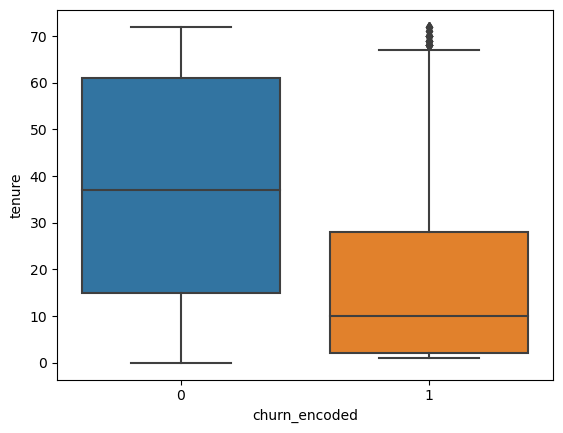

In [49]:
# now to look at the continuous variables
# tenure, monthly_charges, total_charges
sns.boxplot(data=train, y='tenure',x='churn_encoded')
plt.show()


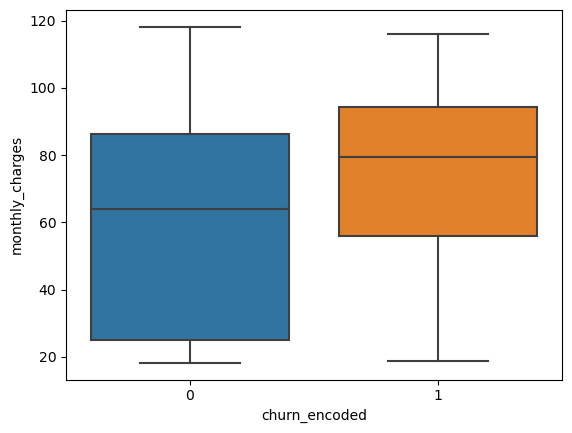

In [50]:
sns.boxplot(data=train, y='monthly_charges',x='churn_encoded')
plt.show()

In [51]:
# Q1 monthly charges for those who churn is ~$55/mo. 
# People don't seem to be churning in significant numbers at the
# in the lower price brackets.
# Test for statistical significance here:

$H_0$: Mean of monthly charges of churned customers >= Mean of monthly charges of all customers

$H_a$: Mean of monthly charges of churned customers < Mean of monthly charges of all customers

In [52]:
monthly_avg = train.monthly_charges.mean()
monthly_charge_churned = train.monthly_charges[train.churn_encoded == 1]
monthly_charge_churned
t, p = stats.ttest_1samp(monthly_charge_churned, monthly_avg)
t, p


(13.647546461800857, 3.814450384596076e-39)

In [53]:
# this is a one-tailed test so 
print(t > 0)
print(p/2 < α)


True
True


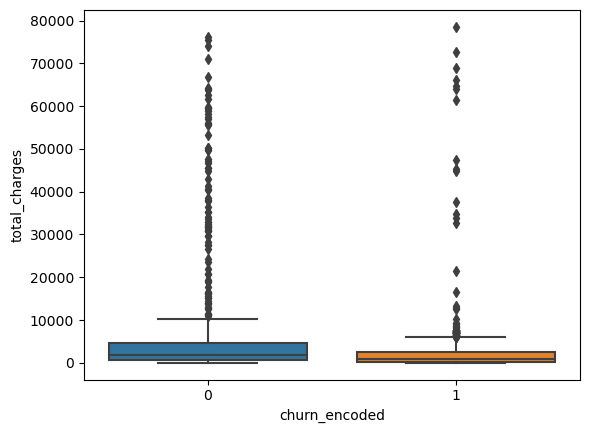

In [54]:
sns.boxplot(data=train, y='total_charges',x='churn_encoded')
plt.show()

In [55]:
train.total_charges.describe()

count     3943.000000
mean      3243.086673
std       6921.534399
min          0.000000
25%        434.025000
50%       1470.950000
75%       4018.000000
max      78560.000000
Name: total_charges, dtype: float64

In [56]:
# looks like mean lifetime revenue from a customer is $3243

## Modeling

In [57]:
# first I need to add the engineered features to val and test:
val['solo_cust'] = (val.partner == 'No') & (val.dependents == 'No')
val['no_cost_to_switch'] = (
    val.online_security == 'No') & (val.online_backup == 'No')
val['pain_points'] = ((val.tech_support == 'No') | 
                        (val.paperless_billing == 'Yes') |
                        (val.payment_type == 'Electronic check'))


In [58]:
test['solo_cust'] = (test.partner == 'No') & (test.dependents == 'No')
test['no_cost_to_switch'] = (
    test.online_security == 'No') & (test.online_backup == 'No')
test['pain_points'] = ((test.tech_support == 'No') | 
                        (test.paperless_billing == 'Yes') |
                        (test.payment_type == 'Electronic check'))

In [59]:
# the new features are booleans so no need to encode.
# I do need to add a baseline column too...
train.churn_encoded.value_counts(normalize=True)
train['baseline_prediction'] = 0
val['baseline_prediction'] = 0
test['baseline_prediction'] = 0


#### **Goal:** The goal of my modeling phase is to build a model that predicts customer churn. I think I have enough evidence for some specific recommendations based on bivariate stats, so I would like this model to use some engineered variables and the other significant drivers of churn to give the client tool to know which customers are likely to churn and maybe allow them to offer some just-in-time incentives to stay.

#### **Features:**
    1. contract_type_encoded
    2. internet_service_type_encoded
    3. senior_encoded
    4. solo_cust
    5. no_cost_to_switch
    6. pain_points
    7. tenure

In [60]:
train.columns.tolist()

['customer_id',
 'gender',
 'senior_citizen',
 'partner',
 'dependents',
 'tenure',
 'phone_service',
 'multiple_lines',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'paperless_billing',
 'monthly_charges',
 'total_charges',
 'churn',
 'internet_service_type',
 'contract_type',
 'payment_type',
 'gender_encoded',
 'partner_encoded',
 'dependents_encoded',
 'phone_service_encoded',
 'paperless_billing_encoded',
 'churn_encoded',
 'multiple_lines_No phone service',
 'multiple_lines_Yes',
 'online_security_No internet service',
 'online_security_Yes',
 'online_backup_No internet service',
 'online_backup_Yes',
 'device_protection_No internet service',
 'device_protection_Yes',
 'tech_support_No internet service',
 'tech_support_Yes',
 'streaming_tv_No internet service',
 'streaming_tv_Yes',
 'streaming_movies_No internet service',
 'streaming_movies_Yes',
 'contract_type_One year',
 'contract_type_Two year',
 'internet

In [61]:
# create X & y version of train, where y is a series 
# with just the target variable and X are all the features. 
features = ['contract_type_One year','contract_type_Two year',
            'internet_service_type_Fiber optic', 'internet_service_type_None', 
            'senior_citizen', 'solo_cust', 'no_cost_to_switch', 'pain_points', 'tenure']
X_train = train[features]
y_train = train.churn_encoded

X_val = val[features]
y_val = val.churn_encoded

X_test = test[features]
y_test = test.churn_encoded


In [62]:
# make the thing

rf1 = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=10, 
                            random_state=9751)


# fit the thing
rf1.fit(X_train, y_train)

# use the thing
rf1_preds = rf1.predict(X_train)

print(f'''
Performance in accuracy of Random Forest 1 on training data:
Accuracy (train): {rf1.score(X_train, y_train)}
Accuracy (validate): {round(rf1.score(X_val, y_val), 2)}''')
print('________________________________________________')
print('________________________________________________')
# classification report:
print(
    classification_report(y_train,
                      rf1_preds))



Performance in accuracy of Random Forest 1 on training data:
Accuracy (train): 0.8227238143545523
Accuracy (validate): 0.79
________________________________________________
________________________________________________
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      2897
           1       0.69      0.60      0.64      1046

    accuracy                           0.82      3943
   macro avg       0.78      0.75      0.76      3943
weighted avg       0.82      0.82      0.82      3943



In [63]:
# rf.classes_
# dict(zip(features, imp))

In [64]:
rf2 = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=2,
                            n_estimators=100,
                            max_depth=7, 
                            random_state=9751)
rf2.fit(X_train, y_train)
rf2_preds = rf2.predict(X_train)
print(f'''
Performance in accuracy of Random Forest 2 on training data:
Accuracy (train): {rf2.score(X_train, y_train)}
Accuracy (validate): {round(rf2.score(X_val, y_val), 2)}''')
print('________________________________________________')
print('________________________________________________')
# classification report:
print(
    classification_report(y_train,
                      rf2_preds))


Performance in accuracy of Random Forest 2 on training data:
Accuracy (train): 0.8029419223941161
Accuracy (validate): 0.8
________________________________________________
________________________________________________
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      2897
           1       0.66      0.52      0.58      1046

    accuracy                           0.80      3943
   macro avg       0.75      0.71      0.73      3943
weighted avg       0.79      0.80      0.79      3943



In [65]:
rf3 = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=6, 
                            random_state=9751)
rf3.fit(X_train, y_train)
rf3_preds = rf3.predict(X_train)
print(f'''
Performance in accuracy of Random Forest 3 on training data:
Accuracy (train): {rf3.score(X_train, y_train)}
Accuracy (validate): {round(rf3.score(X_val, y_val), 2)}''')
print('________________________________________________')
print('________________________________________________')
# classification report:
print(
    classification_report(y_train,
                      rf3_preds))


Performance in accuracy of Random Forest 3 on training data:
Accuracy (train): 0.7998985544002029
Accuracy (validate): 0.79
________________________________________________
________________________________________________
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      2897
           1       0.66      0.51      0.58      1046

    accuracy                           0.80      3943
   macro avg       0.75      0.71      0.72      3943
weighted avg       0.79      0.80      0.79      3943



In [66]:
rf4 = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=4, 
                            random_state=9751)
rf4.fit(X_train, y_train)
rf4_preds = rf4.predict(X_train)
print(f'''
Performance in accuracy of Random Forest 4 on training data:
Accuracy (train): {rf4.score(X_train, y_train)}
Accuracy (validate): {round(rf4.score(X_val, y_val), 2)}''')
print('________________________________________________')
print('________________________________________________')
# classification report:
print(
    classification_report(y_train,
                      rf4_preds))


Performance in accuracy of Random Forest 4 on training data:
Accuracy (train): 0.7950798884098402
Accuracy (validate): 0.8
________________________________________________
________________________________________________
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      2897
           1       0.66      0.46      0.55      1046

    accuracy                           0.80      3943
   macro avg       0.74      0.69      0.71      3943
weighted avg       0.78      0.80      0.78      3943



In [67]:
rf5 = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=3, 
                            random_state=9751)
rf5.fit(X_train, y_train)
rf5_preds = rf5.predict(X_train)
print(f'''
Performance in accuracy of Random Forest 5 on training data:
Accuracy (train): {rf5.score(X_train, y_train)}
Accuracy (validate): {round(rf5.score(X_val, y_val), 2)}''')
print('________________________________________________')
print('________________________________________________')
# classification report:
print(
    classification_report(y_train,
                      rf5_preds))


Performance in accuracy of Random Forest 5 on training data:
Accuracy (train): 0.7768196804463606
Accuracy (validate): 0.79
________________________________________________
________________________________________________
              precision    recall  f1-score   support

           0       0.79      0.95      0.86      2897
           1       0.68      0.30      0.42      1046

    accuracy                           0.78      3943
   macro avg       0.73      0.62      0.64      3943
weighted avg       0.76      0.78      0.74      3943



In [68]:
rf6 = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=2,
                            n_estimators=100,
                            max_depth=8, 
                            random_state=9751)
rf6.fit(X_train, y_train)
rf6_preds = rf6.predict(X_train)
print(f'''
Performance in accuracy of Random Forest 6 on training data:
Accuracy (train): {rf6.score(X_train, y_train)}
Accuracy (validate): {round(rf6.score(X_val, y_val), 2)}''')
print('________________________________________________')
print('________________________________________________')
# classification report:
print(
    classification_report(y_train,
                      rf6_preds))


Performance in accuracy of Random Forest 6 on training data:
Accuracy (train): 0.8082678163834643
Accuracy (validate): 0.8
________________________________________________
________________________________________________
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      2897
           1       0.67      0.54      0.60      1046

    accuracy                           0.81      3943
   macro avg       0.76      0.72      0.74      3943
weighted avg       0.80      0.81      0.80      3943



In [69]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_train)
print(f'''
Performance in accuracy of Random Forest on training data:
Accuracy (train): {rf.score(X_train, y_train)}
Accuracy (validate): {round(rf.score(X_val, y_val), 2)}''')
print('________________________________________________')
print('________________________________________________')
# classification report:
print(
    classification_report(y_train,
                      rf_preds))


Performance in accuracy of Random Forest on training data:
Accuracy (train): 0.8686279482627441
Accuracy (validate): 0.76
________________________________________________
________________________________________________
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      2897
           1       0.76      0.73      0.75      1046

    accuracy                           0.87      3943
   macro avg       0.83      0.82      0.83      3943
weighted avg       0.87      0.87      0.87      3943



In [70]:
# Let's try with a Decision Tree:

In [71]:
clf = DecisionTreeClassifier()

clf.fit(X_train, y_train)
clf_preds = clf.predict(X_train)
print(f'''
Performance in accuracy of Decision Tree on training data:
Accuracy (train): {clf.score(X_train, y_train)}
Accuracy (validate): {round(clf.score(X_val, y_val), 2)}''')
print('________________________________________________')
print('________________________________________________')
# classification report:
print(
    classification_report(y_train,
                      clf_preds))


Performance in accuracy of Decision Tree on training data:
Accuracy (train): 0.8686279482627441
Accuracy (validate): 0.76
________________________________________________
________________________________________________
              precision    recall  f1-score   support

           0       0.89      0.94      0.91      2897
           1       0.80      0.67      0.73      1046

    accuracy                           0.87      3943
   macro avg       0.84      0.81      0.82      3943
weighted avg       0.86      0.87      0.86      3943



In [72]:
clf1 = DecisionTreeClassifier(max_depth=10, min_samples_leaf=5)

clf1.fit(X_train, y_train)
clf1_preds = clf1.predict(X_train)
print(f'''
Performance in accuracy of Decision Tree 1 on training data:
Accuracy (train): {clf1.score(X_train, y_train)}
Accuracy (validate): {round(clf1.score(X_val, y_val), 2)}''')
print('________________________________________________')
print('________________________________________________')
# classification report:
print(
    classification_report(y_train,
                      clf1_preds))


Performance in accuracy of Decision Tree 1 on training data:
Accuracy (train): 0.8168906923662186
Accuracy (validate): 0.77
________________________________________________
________________________________________________
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      2897
           1       0.69      0.55      0.62      1046

    accuracy                           0.82      3943
   macro avg       0.77      0.73      0.75      3943
weighted avg       0.81      0.82      0.81      3943



In [73]:
clf2 = DecisionTreeClassifier(max_depth=8, min_samples_leaf=5)

clf2.fit(X_train, y_train)
clf2_preds = clf2.predict(X_train)
print(f'''
Performance in accuracy of Decision Tree 2 on training data:
Accuracy (train): {clf2.score(X_train, y_train)}
Accuracy (validate): {round(clf2.score(X_val, y_val), 2)}''')
print('________________________________________________')
print('________________________________________________')
# classification report:
print(
    classification_report(y_train,
                      clf2_preds))


Performance in accuracy of Decision Tree 2 on training data:
Accuracy (train): 0.8082678163834643
Accuracy (validate): 0.78
________________________________________________
________________________________________________
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      2897
           1       0.66      0.58      0.62      1046

    accuracy                           0.81      3943
   macro avg       0.76      0.74      0.74      3943
weighted avg       0.80      0.81      0.80      3943



In [74]:
clf3 = DecisionTreeClassifier(max_depth=6, min_samples_leaf=5)

clf3.fit(X_train, y_train)
clf3_preds = clf3.predict(X_train)
print(f'''
Performance in accuracy of Decision Tree 3 on training data:
Accuracy (train): {clf3.score(X_train, y_train)}
Accuracy (validate): {round(clf3.score(X_val, y_val), 2)}''')
print('________________________________________________')
print('________________________________________________')
# classification report:
print(
    classification_report(y_train,
                      clf3_preds))


Performance in accuracy of Decision Tree 3 on training data:
Accuracy (train): 0.7988840984022318
Accuracy (validate): 0.79
________________________________________________
________________________________________________
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      2897
           1       0.63      0.59      0.61      1046

    accuracy                           0.80      3943
   macro avg       0.74      0.73      0.74      3943
weighted avg       0.80      0.80      0.80      3943



In [75]:
clf4 = DecisionTreeClassifier(max_depth=5, min_samples_leaf=5)

clf4.fit(X_train, y_train)
clf4_preds = clf4.predict(X_train)
print(f'''
Performance in accuracy of Decision Tree 4 on training data:
Accuracy (train): {clf4.score(X_train, y_train)}
Accuracy (validate): {round(clf4.score(X_val, y_val), 2)}''')
print('________________________________________________')
print('________________________________________________')
# classification report:
print(
    classification_report(y_train,
                      clf4_preds))


Performance in accuracy of Decision Tree 4 on training data:
Accuracy (train): 0.7968551864062896
Accuracy (validate): 0.8
________________________________________________
________________________________________________
              precision    recall  f1-score   support

           0       0.84      0.89      0.87      2897
           1       0.64      0.53      0.58      1046

    accuracy                           0.80      3943
   macro avg       0.74      0.71      0.72      3943
weighted avg       0.79      0.80      0.79      3943



#### Model Test!

In [76]:
# final test: on the test
# remember! just once! not just once per algorithm!
# use the assessment on your test set *AFTER* you have chosen your best model
print(f'Accuracy of clf4 model on Test data set: {clf4.score(X_test, y_test)}')

Accuracy of clf4 model on Test data set: 0.794180269694819


In [77]:
y_pred = clf4.predict(X_test)
y_pred.mean()

0.19730305180979418

In [87]:
y_preds = pd.Series(y_pred, index=test.customer_id)

In [78]:
X_test.head().T

,5224,1918,2391,5644,4790
contract_type_One year,0,0,0,0,1
contract_type_Two year,1,0,0,0,0
internet_service_type_Fiber optic,0,0,0,0,0
internet_service_type_None,0,1,1,1,0
senior_citizen,0,0,0,0,0
solo_cust,False,True,False,True,False
no_cost_to_switch,True,False,False,False,False
pain_points,False,True,False,False,False
tenure,63,3,22,6,57


In [79]:
y_pred_proba = clf4.predict_proba(X_test)
y_pred_proba

array([[0.98461538, 0.01538462],
       [0.92605634, 0.07394366],
       [0.92605634, 0.07394366],
       ...,
       [0.97826087, 0.02173913],
       [0.68376068, 0.31623932],
       [0.56697819, 0.43302181]])

In [86]:
test_probas = pd.Series(y_pred_proba[:,1], index=test.customer_id)

In [91]:
preds_csv = pd.concat([y_preds, test_probas], axis=1).reset_index()

In [92]:
preds_csv.columns = ['id', 'prediction', 'proba']

In [93]:
preds_csv.to_csv('predictions.csv')

In [81]:
x_ind = X_test.index
x_ind

Int64Index([5224, 1918, 2391, 5644, 4790, 3306, 1457, 4493, 5846, 4998,
            ...
            4696, 3908, 3941, 3793, 3141, 2275, 1313, 6746,    5,   89],
           dtype='int64', length=1409)

In [82]:
X_test.iloc[:,0]

5224    0
1918    0
2391    0
5644    0
4790    1
       ..
2275    1
1313    1
6746    0
5       0
89      0
Name: contract_type_One year, Length: 1409, dtype: uint8

In [83]:
y_pred_df = pd.DataFrame(y_pred)
y_pred_df

,0
0,0
1,0
2,0
3,0
4,0
...,...
1404,0
1405,0
1406,0
1407,0


In [84]:
pd.concat(X_t

/var/folders/pd/dk0dsnvs72ng9hv5mkv2d0980000gn/T/ipykernel_4670/3970242131.py:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  pd.concat(X_test, y_pred_df)


TypeError: first argument must be an iterable of pandas objects, you passed an object of type "DataFrame"

In [ ]:

# classification report:
print(
    classification_report(y_test,
                      y_pred))

In [ ]:
# print(export_text(clf4, feature_names=features))

##### Decision Tree 4 seems to be my best model overall. It has a recall on the positive of .53 and accuracy actually improved slightly for the validation set. Accuracy is above baseline by about 9%

In [ ]:
plt.figure(figsize=(25,25))
plot_tree(clf4,feature_names=features)
plt.show()

In [ ]:
print(classification_report(y_train, train.baseline_prediction))